# Load and visualize EEG data

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import os
from glob import glob

import h5py
from collections import namedtuple
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
## Paths
base_dir = Path('/data/ronan/grasp-and-lift-eeg-detection')
raw_dir = base_dir / 'raw' / 'train'

# Columns name for labels
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

# Number of subjects
subjects = range(1,13)

#
TAG = ''

## Data Loaders

In [3]:
def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels

def get_raw_data(data_dir, subjects):
    y = []
    X = []
    sub_list = []
    for i,subject in enumerate(subjects):
        ################ READ DATA ################################################
        fnames =  glob(str(data_dir / f'subj{subject}_series*_data.csv'))
        for fname in fnames:
            data,labels=prepare_data_train(fname)
            X.append(np.asarray(data))
            y.append(np.asarray(labels))
            sub_list.append(subject)

    return (X, y, np.asarray(sub_list))

## Helper Functions

In [4]:
def consecutive_regions(a, val=1):
    """
    Parameters
    ----------
    a : 1-D array
    
    Returns
    -------
    Returns a list of regions where value `val` is in array `a`
    Regions in a named tuple of start index and length
    """
    Region = namedtuple('Region', ['start', 'length'])
    regions = []
    hit = False
    start_idx = None
    for i,d in enumerate(a):
        if d == val and hit == False:
            hit = True
            start_idx = i
        elif not d == val and hit == True:
            hit = False
            regions.append(Region(start_idx, i - start_idx))
            
    if hit == True:
        regions.append(Region(start_idx, len(a) - start_idx))
        
    return regions

def get_region_dict(data, cols):
    """
    Parameters
    ----------
    data : 2-D array-like of labels
        rows = timesteps, cols = classes
    
    Returns
    -------
    Returns dictionary of regions for each classification label 
    in `cols` and `None`
    """
    region_dict = dict()
    zeros_all = np.sum(data, axis=1)
    
    region_dict['None'] = consecutive_regions(zeros_all, val=0)
    
    for label, array in zip(cols, data.T):
        region_dict[label] = consecutive_regions(array, val=1)
        
    return region_dict

def sample_active_sites(regions, data, label, prelag=500, postlag=500):
    """
    Samples regions from motion sides with specified lags

    Parameters
    ----------
    data : 2-D array-like
        rows = sensors, cols = timesteps
        
    Returns
    -------
    X : array of flattened (#channels x #timesteps) matrix with 
        prelag steps before action and postlag steps after
    y : class label for each flattened matrix
    
    """
    X = []
    y = []
    for region in regions:
        if region.start >= prelag:
            X.append(data.T[:, region.start-prelag: region.start+postlag].flatten())
            y.append(label)
            
    return(np.asarray(X), np.asarray(y))

def sample_inactive_sites(regions, data, label, prelag=500, postlag=500):
    """
    Samples max number of independent regions of inactive sites
    
    Parameters
    ----------
    data : 2-D array-like
        rows = sensors, cols = timesteps
        
    Returns
    -------
    X : array of flattened (#channels x #timesteps) matrix with 
        prelag steps before action and postlag steps after
    y : class label for each flattened matrix
    
    """
    X = []
    y = []
    for region in regions:
        lag = (prelag + postlag)
        num_intervals = int(region.length / lag)
        for n in range(num_intervals - 1):
            X.append(data.T[:, region.start+postlag+n*lag: region.start+postlag+(n+1)*lag].flatten())
            y.append(label)
            
    return(np.asarray(X), np.asarray(y))

## Make Features
Pipeline per subject
1. Load all series from a subject (series x timesteps x channels)
2. Convert each series to class class (series x class x tuples(start, length))
3. Sample active sites from regions (series*class x (channels x timesteps))
4. Concatenate samples from each series (X,y)
5. Save to file

In [34]:
# Subject to load
subject = 1
prelag = 0
postlag = 150

In [35]:
# -> (series x (timesteps x channels))
print(f'Loading data from {raw_dir}')
X_raw,y_raw,subs = get_raw_data(raw_dir, [subject])

Loading data from /data/ronan/grasp-and-lift-eeg-detection/raw/train


In [38]:
# Standardize
scaler = StandardScaler()
X_raw = [scaler.fit_transform(Xr) for Xr in X_raw]

In [39]:
# -> (series x dict{class, tuples(start, length)})
region_dicts = [get_region_dict(y_series, cols) for y_series in y_raw]

In [40]:
# -> (class*series x (channels x timesteps))
X = []
y = []
for series, region_dict in enumerate(region_dicts):
    Xi, yi = sample_active_sites(region_dict['None'], X_raw[series], label=0, prelag=prelag, postlag=postlag)
    X.append(Xi)
    y.append(yi)
    for i,key in enumerate(cols):
        Xi, yi = sample_active_sites(region_dict[key], X_raw[series], label=i+1, prelag=prelag, postlag=postlag)
        X.append(Xi)
        y.append(yi)

In [41]:
# Concatenate samples from each series -> (X,y)
X = np.concatenate(X, axis=0)
y = np.concatenate(y)

(2438, 4800)


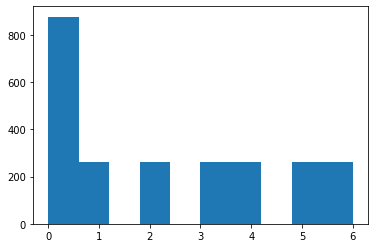

In [42]:
print(X.shape)
plt.hist(y)
plt.show()

In [43]:
# Save
save_dir = base_dir / 'processed'

if not os.path.exists(save_dir): 
    os.makedirs(save_dir)

h5f = h5py.File(save_dir / f'subj{subject}_prelag={prelag}_postlag={postlag}_{TAG}_Xy.hdf5', 'w')
h5f.create_dataset('X', data=X)
h5f.create_dataset('y', data=y)

h5f.close()